# Cloud points view of a mesh

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Now I have to try to generate a point cloud along the edges to simulate STORM images.

### Loading a tyssue dataset 

In [1]:
import pandas as pd
import numpy as np

from tyssue.io import hdf5
from tyssue import config
from tyssue.core.monolayer import Monolayer

import matplotlib.pyplot as plt
%matplotlib qt
import seaborn as sns

In [2]:
datasets = hdf5.load_datasets('small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} s_{ij}, \quad s \in [0, 1]$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [56]:
mean_length = monolayer.edge_df.length.mean()
delta_s = 0.02 * mean_length

mesh = monolayer.edge_df[['length',] + monolayer.dcoords].copy()
mesh['num_particles'] = (monolayer.edge_df.length/delta_s).astype(np.int)

# Increase points density in the apical and basal layers
mesh.loc[monolayer.apical_edges, 'num_particles'] *= 10
mesh.loc[monolayer.basal_edges, 'num_particles'] *= 10

n_points = mesh['num_particles'].sum()
points = pd.DataFrame(np.zeros((n_points, 3)), 
                      columns=monolayer.coords)

# integer index for the points in each edge
curv_indexer = np.repeat(np.arange(mesh.shape[0]), 
                         mesh['num_particles'])

# the s coordinate from 0 to 1
ramps = np.concatenate([np.linspace(0, 1, ns) 
                        for ns in mesh['num_particles']])

srce_pos = monolayer.upcast_srce(
        monolayer.vert_df[monolayer.coords]).loc[curv_indexer]

for c in monolayer.coords:
    points[c] = (srce_pos[c].values + ramps *
                 mesh['d'+c].loc[curv_indexer].values)

assert curv_indexer.max() + 1 == mesh.shape[0]

print('N edges: {}, N points: {}'.format(mesh.shape[0],
                                         curv_indexer.shape[0]))

real_edge_length = 1000 #in nm
points = points * real_edge_length 


N edges: 1656, N points: 259112


Add some noise to the mix

In [60]:
pos_noise = 5

pos_noise = np.random.normal(scale=pos_noise, size=(points.shape[0], 3))
points[monolayer.coords] += pos_noise

points.head()

,x,y,z
0,498.706904,-34.038047,-982.551011
1,504.448488,-43.281618,-996.272189
2,508.489212,-41.000740,-987.736593
3,510.951419,-26.931863,-983.952028
4,513.879157,-24.983446,-983.758376


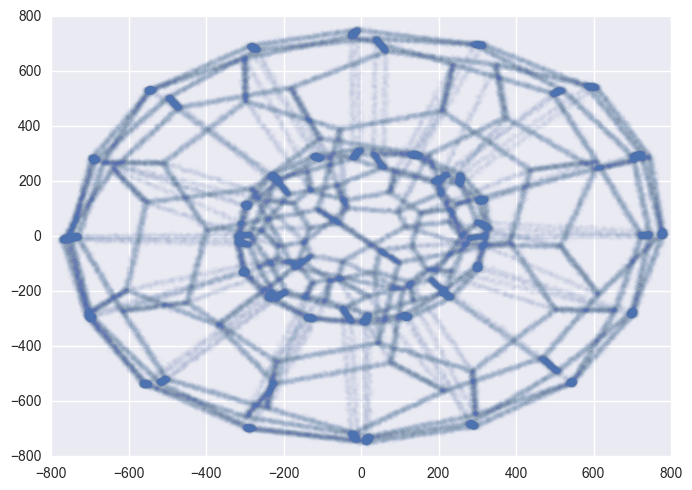

In [59]:
fig, ax = plt.subplots()
ax.plot(*points[['x', 'y']].T.values, '.', alpha=0.01)
fig

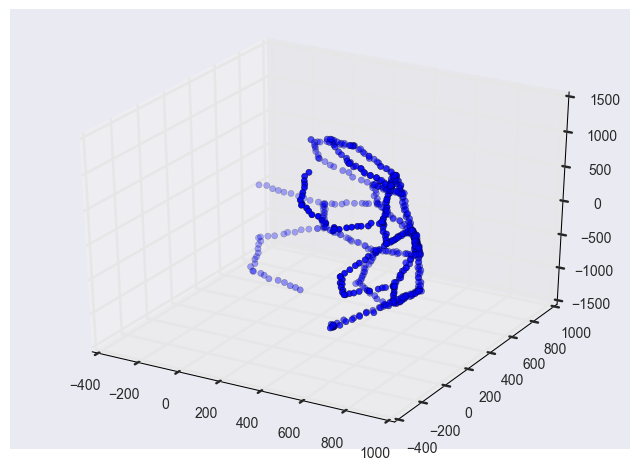

In [8]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = points[monolayer.coords].values[:600].T
ax.scatter(xs, ys, zs)
fig

### The 3D Storm format

In [8]:
ls ../tyssue/visualisation/

3D_STORM_format.png  Visualization.ipynb


Here is a screen shot of the file provided by Christophe:

![Crop of the 3D_STORM format in a tabulator](../tyssue/visualisation/3D_STORM_format.png)

In [62]:
columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
           'uncertainty_xy', 'uncertainty_z']
storm_points = pd.DataFrame(np.zeros((points.shape[0], 6)), 
                            columns=columns)

# Putting each segment in a different frame
frame = monolayer.edge_df['length'].copy()
frame.loc[monolayer.apical_edges] = 1
frame.loc[monolayer.basal_edges] = 2
frame.loc[monolayer.sagittal_edges] = 3
frame = frame.loc[curv_indexer].astype(np.int)


storm_points[['x [nm]', 'y [nm]', 'z [nm]']] = points[monolayer.coords].dropna()
storm_points['frame'] = frame.values
storm_points[['uncertainty_xy', 'uncertainty_z']] = 2.1

# tab separated values are faster and more portable than excel
#storm_points.to_csv('ellipsoid_points.csv', index=False, header=True, sep='\t')

# separated files per segment
storm_points.groupby('frame').apply(
    lambda df:df.to_csv(
        'ellipsoid_points_{}.csv'.format(df['frame'].iloc[0]),
        index=False, header=True, sep='\t'))


""


Now you can upload `ellipsoid_points.csv`, to [Felix's website](http://cake23.de/pointcloud-loader/) and voilà!
![Awesome](../data/png/tyssue_storm.png)


In [49]:
!head ellipsoid_points.csv

frame	x [nm]	y [nm]	z [nm]	uncertainty_xy	uncertainty_z
1	513.4953142107144	-34.39324169927636	-985.173383718094	2.1	2.1
1	523.5734751966091	-3.1408290306174926	-981.0282490797375	2.1	2.1
1	533.6516361825039	28.111583638041374	-976.8831144413809	2.1	2.1
1	543.7297971683986	59.36399630670023	-972.7379798030245	2.1	2.1
1	553.8079581542934	90.6164089753591	-968.5928451646679	2.1	2.1
1	563.8861191401883	121.86882164401797	-964.4477105263114	2.1	2.1
1	573.964280126083	153.12123431267682	-960.3025758879548	2.1	2.1
1	584.0424411119778	184.37364698133567	-956.1574412495984	2.1	2.1
1	594.1206020978725	215.62605964999457	-952.0123066112418	2.1	2.1


In [14]:
!ls -lh | grep xls

-rw-r--r-- 1 guillaume guillaume 1,7M oct.  28 09:08 ellipsoid_points.xls


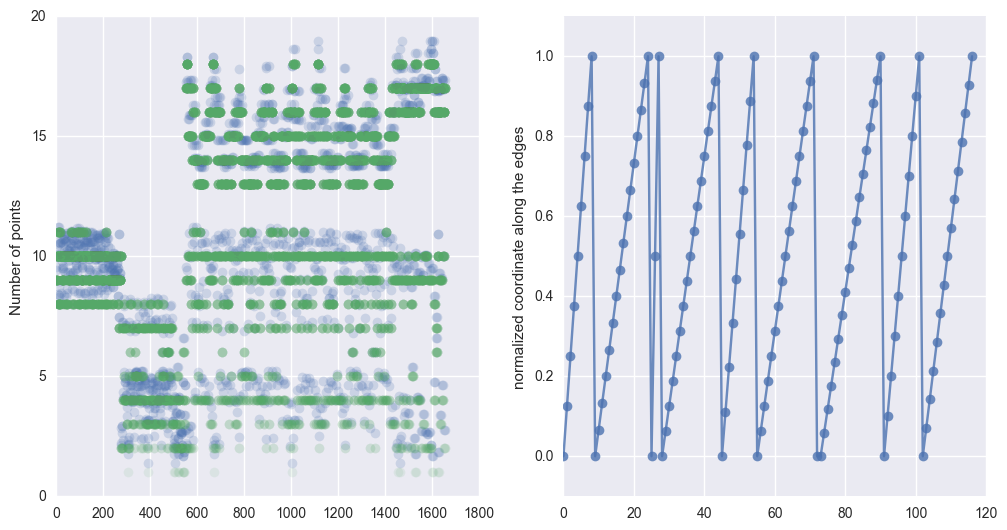

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(mesh.length.values/delta_s, 'o', alpha=0.2)
ax0.plot(upcast_nij, 'o', alpha=0.1)
ax0.set_ylabel('Number of points')

e_start, e_stop = 1000, 1010

p_start, p_stop = (curv_indexer[curv_indexer < e_start].size,
                   curv_indexer[curv_indexer < e_stop].size )

ax1.plot(ramps[p_start: p_stop], '-o', alpha=0.8)
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('normalized coordinate along the edges')

fig.set_size_inches((12, 6))
fig